preliminary analysis
281.28491982653304


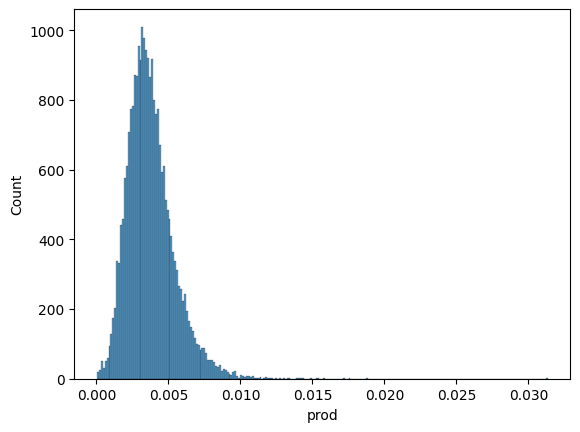

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


print("preliminary analysis")
df = pd.read_excel('data.xlsx')

# Рассчитываем эффективность
df['efficiency'] = (
    df['all_system_fact']-df['break_fact']-df['additional_fact']
) / df['all_system_fact']



df["prod"] = (df["cnt_call"]+ df["cnt_chat"])/(df["dlg_time_call"] + df["dlg_time_chat"])
sns.histplot(df["prod"])
print(1/df["prod"].median())

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Первый квартиль (25%)
    Q3 = df[column].quantile(0.75)  # Третий квартиль (75%)
    IQR = Q3 - Q1                   # Межквартильный размах

    # Определяем границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтруем данные, оставляя только значения в пределах границ
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

df['id'] = list(range(len(df)))
moscow_df = df[df["residential_city_nm"] == "г Москва"].copy()
df = remove_outliers_iqr(df, 'skill_group_exp')

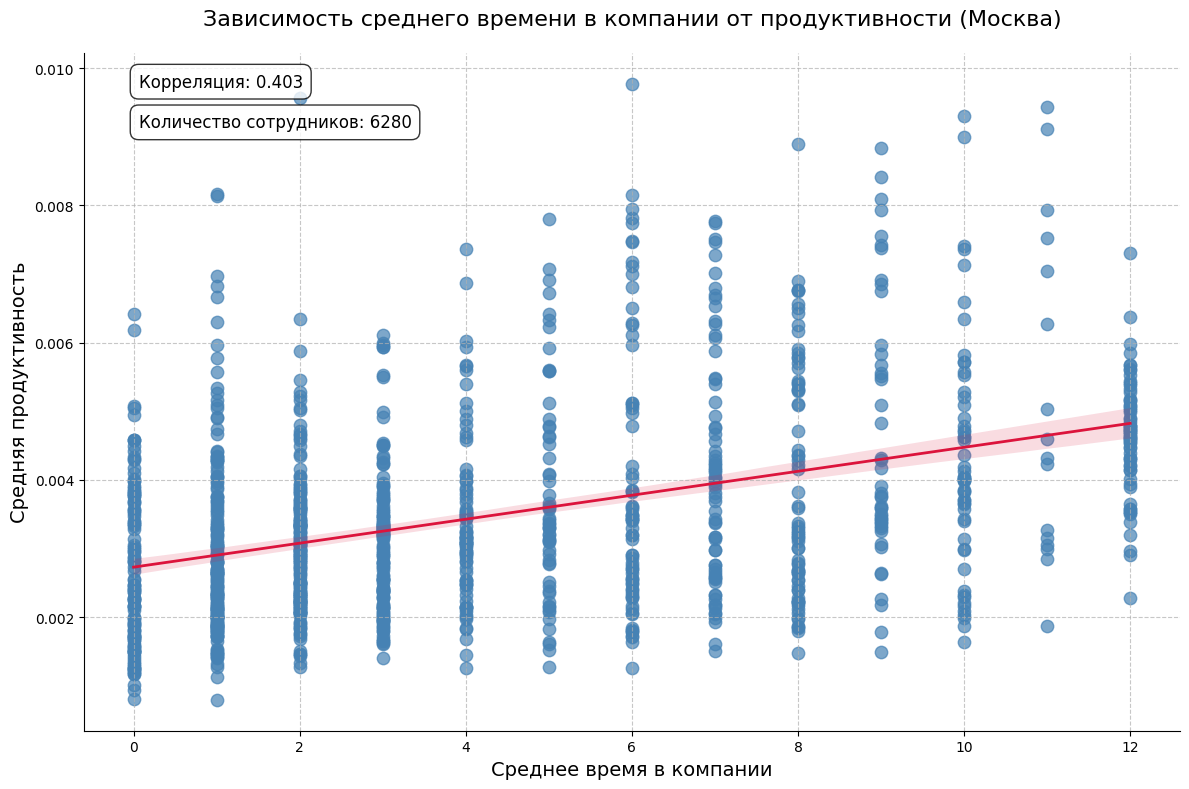

In [10]:
employee_stats = moscow_df.groupby('id').agg({
    'prod': 'median',
    'skill_group_exp': 'median'  # Замените на вашу колонку с временем в компании
}).reset_index()

# Создаем график
plt.figure(figsize=(12, 8))

# Scatter plot с регрессионной линией
sns.regplot(
    data=employee_stats,
    x='skill_group_exp',
    y='prod',  # Замените на вашу колонку
    scatter_kws={
        "alpha": 0.7,
        "s": 80,
        "color": "steelblue"
    },
    line_kws={
        "color": "crimson",
        "lw": 2
    }
)

# Улучшаем внешний вид графика
plt.title('Зависимость среднего времени в компании от продуктивности (Москва)', fontsize=16, pad=20)
plt.ylabel('Средняя продуктивность', fontsize=14)
plt.xlabel('Среднее время в компании', fontsize=14)  # Измените название по необходимости
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем аннотацию с коэффициентом корреляции
correlation = employee_stats['prod'].corr(employee_stats['skill_group_exp'])
plt.annotate(
    f"Корреляция: {correlation:.3f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Добавляем информацию о количестве сотрудников
plt.annotate(
    f"Количество сотрудников: {len(employee_stats)}",
    xy=(0.05, 0.89),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Настраиваем стиль
sns.despine()
plt.tight_layout()
plt.show()

In [11]:
plt.scatter(moscow_df['skill_group_exp', moscow_df['prod']])

InvalidIndexError: ('skill_group_exp', 62             NaN
69             NaN
90             NaN
101       0.004168
126            NaN
            ...   
170647         NaN
170707         NaN
170719         NaN
170755         NaN
170763         NaN
Name: prod, Length: 6280, dtype: float64)